# **Transfer Learning: MNIST to FMNIST**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **MNIST:**
    * MNIST - Modified National Institute of Standards and Technology
    * Image Size: 28x28 pixels
    * Total Images: 70,000 (60,000 training, 10,000 testing)
    * Channels: Grayscale, 1 channel

* **FMNIST:**
    * FMNIST - Fashion-MNIST
    * Image Size: 28x28 pixels
    * Total Images: 70,000 (60,000 training, 10,000 testing)
    * Channels: Grayscale, 1 channel

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import torchvision and transformations libraries
import torchvision as tv
import torchvision.transforms as T

# additional libraries 
import copy

_________________________
**Accessing Dataset**

In [2]:
cd ..

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning


In [3]:
cd datasets

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning/datasets


______________

In [4]:
# import dataset (MNIST)
data=np.loadtxt(open('mnist/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove them from data
labels=data[:,0]
data=data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

# NEW: reshape to 2D!
dataNorm=dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [5]:
# Create train/test groups using DataLoader

# step 1: convert to tensor
dataT=tr.tensor(dataNorm).float()
labelsT=tr.tensor(labels).long()

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labelsT,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

print(train_data.tensors[0].shape)
print(test_data.tensors[0].shape)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


torch.Size([18000, 1, 28, 28])
torch.Size([2000, 1, 28, 28])


In [6]:
# import Dataset (FMNIST)

# transformations
transform=T.Compose([T.ToTensor(),T.Normalize(.5,.5)])

# import the data and simultaneously apply the transform
trainset=tv.datasets.FashionMNIST(root='./fmnist',train=True,download=True,transform=transform)
testset=tv.datasets.FashionMNIST(root='./fmnist',train=False,download=True,transform=transform)

print(trainset.data.shape)
print(testset.data.shape)

# translate into dataloader objects
batchsize=32
fashion_train_loader=DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader=DataLoader(testset,batch_size=len(testset))

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
# creating a class for the model
def create_MNIST_NET(printtoggle=False):
    class mnistNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers
            self.conv1=nn.Conv2d(1,10,kernel_size=5,stride=1,padding=1)
            ##### size: np.floor((28+2*1-5)/1)+1 = 26/2 = 13 (/2 because of maxpool)

            # self.conv2=nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            # ##### size: np.floor((28+2*1-5)/1)+1 = 22/2 = 11 (/2 because of maxpool)

            # compute the number of units in FC layer (no of outputs of conv2)
            # expectSize=np.floor((5+2*0-1)/1)+1 # fc1 layer has no padding or kernel, so
            # expectSize=20*int(expectSize**2)

            ### single convolution layer configuration
            expectSize=np.floor((13+2*0-1)/1)+1 # fc1 layer has no padding or kernel, so
            expectSize=10*int(expectSize**2)

            # fully-connected layer
            self.fc1=nn.Linear(expectSize,50)

            # output layer
            self.out=nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print=printtoggle

        # forward propogation
        def forward(self,x):
            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu (1)
            x=F.relu(F.max_pool2d(self.conv1(x),2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu (2)
            # x=F.relu(F.max_pool2d(self.conv2(x),2))
            # print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            ### x.shape.numel() -->  gives total number of elements in the array/tuple
            nUnits=x.shape.numel()/x.shape[0]
            ### vectorizing
            x=x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None
            
            # linear layers
            x=F.relu(self.fc1(x))
            print(f'Layer fc1: {x.shape}') if self.print else None
            x=self.out(x)
            print(f'Layer fc1: {x.shape}') if self.print else None

            return x
    
    # create the model instance
    net=mnistNet(printtoggle)

    # loss function
    lossfun=nn.CrossEntropyLoss()

    # optimizer
    optimizer=tr.optim.Adam(net.parameters(),lr=0.01)
    
    return net,lossfun,optimizer

In [8]:
# test the model with one batch

net,lossfun,optimizer=create_MNIST_NET(True)
X,y=next(iter(train_loader))
yHat=net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Vectorize: torch.Size([32, 1690])
Layer fc1: torch.Size([32, 50])
Layer fc1: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3319, grad_fn=<NllLossBackward0>)


In [9]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Vectorize: torch.Size([2, 1690])
Layer fc1: torch.Size([2, 50])
Layer fc1: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Linear-2                   [-1, 50]          84,550
            Linear-3                   [-1, 10]             510
Total params: 85,320
Trainable params: 85,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.33
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


In [10]:
# function to train the model 

def trainModel(net,train_loader,test_loader,nepochs=10):

    # no of epochs
    numepochs=nepochs

    # create a new model
    lossfun,optimizer=nn.CrossEntropyLoss(),tr.optim.Adam(net.parameters(),lr=0.01)

    # initialize losses
    losses=tr.zeros(numepochs)
    trainAcc=[]
    testAcc=[]

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc=[]
        batchLoss=[]

        for X,y in train_loader:

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches=tr.argmax(yHat,axis=1) == y         # booleans (false/true)
            matchesNumeric=matches.float()              # convert to numbers (0/1)
            accuracyPct=100*tr.mean(matchesNumeric)     # average x 100
            batchAcc.append(accuracyPct)                # add list of accuracies
        # end of batch loop...
        
        # now that we have trained through batches, get their averages training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi]=np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y=next(iter(test_loader))     # extract X,y from test dataloader\
        with tr.no_grad():              # deactivates autograd
            yHat=net(X)
        
        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100*tr.mean((tr.argmax(yHat,axis=1)==y).float()))
        print(f"{epochi+1}/{nepochs} complete!")
    # end epochs
    
    # function output
    return  trainAcc,testAcc,losses,net

In [11]:
# Run the model and show the results!
net,lossfun,optimizer=create_MNIST_NET()
# training the source model on numbers:
trainAcc,testAcc,losses,num_net=trainModel(net,train_loader,test_loader,nepochs=3)

1/3 complete!
2/3 complete!
3/3 complete!


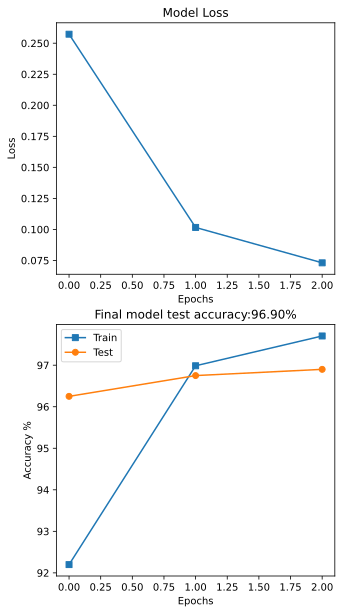

In [12]:
# Results on MNIST dataset of the num_net
fig,ax=plt.subplots(2,1,figsize=(5,10))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc,'s-',label="Train")
ax[1].plot(testAcc,'o-',label="Test")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

In [13]:
# Test on FMNIST dataset:
X,y=next(iter(fashion_test_loader))     # extract X,y from test dataloader
yHat=num_net(X)

# compare the following really long line of code to the training accuracy lines
fashionAcc=100*tr.mean((tr.argmax(yHat,axis=1)==y).float())

print(f"num_net performance on FASHION data: {fashionAcc:.2f} %")

num_net performance on FASHION data: 11.05 %


In [14]:
### Fine tune the model with one training batch

# create the target model
fashion_net,lossfun,optimizer=create_MNIST_NET()

# then replace all the weights in the target model from Source model
for target,source in zip(fashion_net.named_parameters(),num_net.named_parameters()):
    target[1].data=copy.deepcopy(source[1].data)

In [15]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )

In [16]:
# now re-train the network on the fashion data (only one epoch/  one batch of training)
trainAcc,testAcc,losses,fashion_net=trainModel(fashion_net,fashion_train_loader,fashion_test_loader,nepochs=1)

1/1 complete!


In [17]:
print(f'transfer train accuracy: {trainAcc[-1]:.2f}')
print(f'transfer test accuracy: {testAcc[-1]:.2f}')

transfer train accuracy: 63.81
transfer test accuracy: 78.57


In [18]:
# Trying fashion_net without transfer learning:
# create the target model
fashion_net,lossfun,optimizer=create_MNIST_NET()
trainAcc,testAcc,losses,fashion_net=trainModel(fashion_net,fashion_train_loader,fashion_test_loader)
print(f'train accuracy: {trainAcc[-1]:.2f}')
print(f'test accuracy: {testAcc[-1]:.2f}')

1/10 complete!
2/10 complete!
3/10 complete!
4/10 complete!
5/10 complete!
6/10 complete!
7/10 complete!
8/10 complete!
9/10 complete!
10/10 complete!
train accuracy: 89.74
test accuracy: 87.95


**Additional Explorations**

In [19]:
# 1) We ran 5 epochs of training, and saw a nice boost in transfer learning. However, it looks like the initial training on the numbers wasn't finished. Do you think the transfer learning boost will be higher if you train the initial model longer? Test it to find out!
# It gives better transfer learning accuracy when MNIST is trained on less number of epochs

# 2) Do transfer learning the other way around: Train the model on the fashion data, then apply it to the number data. Before running the model, think about the model architecture, the nature of the images, and make a prediction about whether you would expect number->fashion or fashion->number to transfer better (that is, which would have higher accuracy from one epoch of training). Is your prediction confirmed?